In [20]:
import gc
gc.enable()

import time
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# plt.rcParams['figure.figsize']=[6,3]
# plt.rcParams['figure.dpi']=80
from tqdm import tqdm_notebook as tqdm
import os
import pandas as pd 
import numpy as np
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

#Convert infinite value to NULL
pd.options.mode.use_inf_as_na = True
# [var for var in data if data[var] is np.isinf]

from IPython.display import display
import matplotlib.pyplot as plt3

import holidays 
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [21]:
def holiday_name(x):
    # Cheking whether given data is a holiday
    India_holidays_list = holidays.India()
    if x in India_holidays_list:
        return India_holidays_list.get(x)
    else:
        return 'No_Holiday'
    
def isholiday(x):
    # Cheking whether given data is a holiday
    India_holidays_list = holidays.India()
    if x in India_holidays_list:
        return 1
    else:
        return 0

In [22]:
train = pd.read_csv("train_E1GspfA.csv")
# train['holiday_name'] = train['date'].apply(holiday)
# train['IsHoliday'] = train['date'].apply(isholiday)
# # train.set_index('date', inplace=True)
# train.head(1000)

In [23]:
test = pd.read_csv("test_6QvDdzb.csv")
# test['holiday_name'] = test['date'].apply(holiday)
# test['IsHoliday'] = test['date'].apply(isholiday)
# test.head(100)

In [24]:
# import time
# def datetounix(df):
#     # Initialising unixtime list
#     unixtime = []
#     df.date = pd.to_datetime(df.date, dayfirst = True)
#     # data.WeekEnding_Date = pd.to_datetime(data.WeekEnding_Date, format="%Y-%m-%d", errors="coerce")

#     # Check if the conversion is successful
#     assert df.date.dtype == "datetime64[ns]"
#     # Running a loop for converting Date to seconds
#     for date in df['date']:
#         unixtime.append(time.mktime(date.timetuple()))
    
#     # Replacing Date with unixtime list
#     df['date_unix'] = unixtime
#     return(df)
# train=datetounix(train)
# test = datetounix(test)
# train.head()

In [25]:
test['demand'] = np.nan
df = pd.concat([train, test])
df.reset_index(drop=True, inplace=True)
print(train.shape, test.shape, df.shape)

# #freq encoding
# col = 'holiday_name'
# enc_nom_1 = (df.groupby(col).size()) / len(df)
# df['holiday_name'] = df[col].apply(lambda x : enc_nom_1[x])

# #freq encoding
# col = 'hour'
# enc_nom_1 = (df.groupby(col).size()) / len(df)
# df['hour'] = df[col].apply(lambda x : enc_nom_1[x])

target   = 'demand'
train = df[df[target].isnull()!=True]
test  = df[df[target].isnull()==True]
test.drop(target, axis=1, inplace=True)

train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

(18247, 3) (7650, 3) (25897, 3)


In [26]:
pjme = train.copy()
split_date = '2020-11-01'
# split_date = '2020-02-01'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [27]:
# # sns.distplot(train['hour'])
# from sklearn.preprocessing import KBinsDiscretizer
# def kbindicretizer(train_data, test_data= None, n_bins = None):
#     discrete1 = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans')
#     disc = discrete1.fit(pd.DataFrame({'hour': train_data['hour']}))
#     print('Edges: {}'.format(disc.bin_edges_))
#     train_data['age_disc_kmeans'] = disc.transform(pd.DataFrame({'age': train_data['age']}))
#     return train_data
# # concat = kbindicretizer(concat, n_bins=6)
# # concat.head()

In [28]:
def create_features(df, date, label=None):
    #df['year'] = pd.DatetimeIndex(df[date]).year # == As Year And Seasons Are Same
    df['date'] = df.index
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = pd.DatetimeIndex(df[date]).month
    df['day'] = pd.DatetimeIndex(df[date]).day
    df['day_of_year'] = pd.DatetimeIndex(df[date]).dayofyear
    df['week_of_year'] = pd.DatetimeIndex(df[date]).weekofyear
    df['quarter'] = pd.DatetimeIndex(df[date]).quarter
    df['seasons'] = df['month'] % 12 // 3 + 1
    df['weekday'] = pd.DatetimeIndex(df[date]).dayofweek
    #     df['is_month_start'] = pd.DatetimeIndex(df[date]).is_month_start
    #     df['is_month_end'] = pd.DatetimeIndex(df[date]).is_month_end
    #     df['is_quarter_start'] = pd.DatetimeIndex(df[date]).is_quarter_start
    #     df['is_quarter_end'] = pd.DatetimeIndex(df[date]).is_quarter_end
    #     df['is_year_start'] = pd.DatetimeIndex(df[date]).is_year_start
    #     df['is_year_end'] = pd.DatetimeIndex(df[date]).is_year_end
    #     df['is_leap_year'] = pd.DatetimeIndex(df[date]).is_leap_year
    
    # Cyclical encoding for day:
    df['day_sin'] = np.sin(2 * np.pi * df['day']/7.0)
    df['day_cos'] = np.cos(2 * np.pi * df['day']/7.0)

    # Cyclical encoding for month:
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12.0)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12.0)    
    #df.drop(['year'], inplace=True, axis=1)
    #df['year'] = df['year'].astype('O')
    #df['day_ratio'] = df['day']/df['day']
    
    for var in df.select_dtypes('boolean').columns:
        mapper = {j: i for i, j in enumerate(df[var].unique().tolist(), 0)}
        df[var] = df[var].map(mapper)
        
    if label:
        y = df[label]
        df.drop(['date', 'demand'], inplace=True, axis=1)
        return df, y
    df.drop(['date'], inplace=True, axis=1)
    return df

In [29]:
X_train, y_train = create_features(pjme_train, 'date', label='demand')
X_test, y_test = create_features(pjme_test, 'date', label='demand')

In [30]:
X_train.head()

,hour,year,month,day,day_of_year,week_of_year,quarter,seasons,weekday,day_sin,day_cos,month_sin,month_cos
date,,,,,,,,,,,,,
2018-08-18,9,2018,8,18,230,33,3,3,5,-0.433884,-0.900969,-0.866025,-0.5
2018-08-18,10,2018,8,18,230,33,3,3,5,-0.433884,-0.900969,-0.866025,-0.5
2018-08-18,13,2018,8,18,230,33,3,3,5,-0.433884,-0.900969,-0.866025,-0.5
2018-08-18,14,2018,8,18,230,33,3,3,5,-0.433884,-0.900969,-0.866025,-0.5
2018-08-18,15,2018,8,18,230,33,3,3,5,-0.433884,-0.900969,-0.866025,-0.5


R : 29.617482100308116
R : 34.121205388705185


<AxesSubplot:>

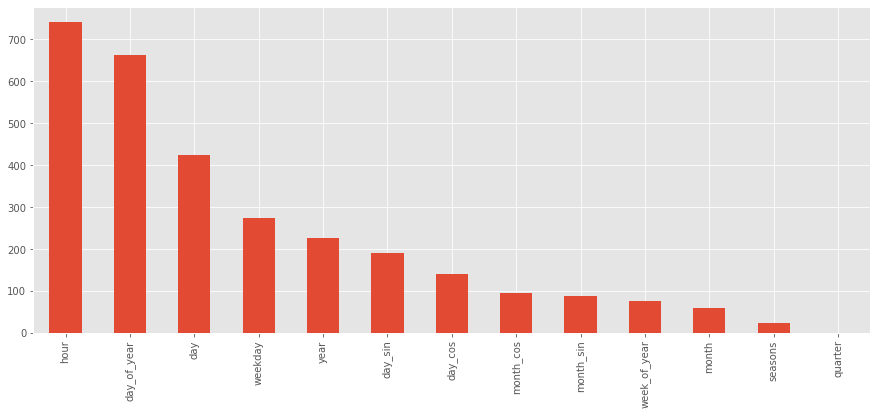

In [31]:
# X, y = create_features(pjme, 'date', label='demand')
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
# param_lgbm = {'device': 'cpu',
#               'metric': 'mse', 
#               'boosting_type': 'gbdt', 'num_leaves': 740, 'max_depth': 121, 'learning_rate': 0.9667145579408727, 'n_estimators': 472, 'min_child_weight': 0.01, 'min_child_samples': 5, 'colsample_bytree': 0.6808372313587183, 'feature_fraction': 0.6653479701653351, 'bagging_fraction': 0.799105429993653, 'bagging_freq': 7, 'lambda_l1': 1.2463829770341894e-06, 'lambda_l2': 4.059084549930808e-05, 'random_state': 78}
# model = LGBMRegressor(**param_lgbm,n_jobs= 11) 
# model.fit(X_train, y_train, eval_set = [(X_train, y_train),(X_test, y_test)], eval_names = ['train', 'valid'],
#                   eval_metric='mse', early_stopping_rounds = 100, verbose = 100)
# model.fit(X, y, eval_set = [(X_train, y_train),(X_test, y_test)], eval_names = ['train', 'valid'],
#                   eval_metric='mse', 
#               early_stopping_rounds = 100, verbose = 100)
model = LGBMRegressor(n_jobs= 11) 
model.fit(X_train,y_train)
y_pred = model.predict(X_train)
rmse_result = np.sqrt(mean_squared_error(y_train,y_pred))
print('R : {}'.format(rmse_result))

y_pred = model.predict(X_test)
rmse_result = np.sqrt(mean_squared_error(y_test, y_pred))
print('R : {}'.format(rmse_result))

#error.append(rmse_result)
feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp.nlargest(60).plot(kind='bar', figsize=(15,6))

In [32]:
##test
test_t = create_features(test, 'date')
test_df = model.predict(test_t)

test = pd.read_csv("test_6QvDdzb.csv")
# test.head()
sub = pd.DataFrame()
sub = test[['date', 'hour']]
sub['demand'] = test_df#p.round(np.expm1(np.maximum(reg.predict(test_t), 0.0)))
sub.to_csv(f"Submission_L{time.strftime('%Y%m%d_%H%M')}.csv", index=False)

In [33]:
sub.head()

,date,hour,demand
0,2021-03-01,0,56.546609
1,2021-03-01,1,55.308932
2,2021-03-01,2,55.308932
3,2021-03-01,3,54.969940
4,2021-03-01,5,55.208121


In [26]:
from catboost import CatBoostRegressor
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
cbst_par = {'depth': 8, 'learning_rate': 0.16681109764986363, 'max_bin': 208, 'min_data_in_leaf': 154, 
            'l2_leaf_reg': 0.0004109366557801251, 'bagging_temperature': 4.102428660699969, 
            'grow_policy': 'SymmetricTree', 'leaf_estimation_method': 'Newton', 'random_state': 309}
reg = CatBoostRegressor(random_seed=42, iterations = 5000)
# reg.fit(X_train, y_train, plot=True,
#         eval_set=[(X_train, y_train), (X_test, y_test)], #eval_metric='RMSE',
#         early_stopping_rounds=50, verbose=False)
# reg = CatBoostRegressor(**cbst_par)
reg.fit(X_train, y_train, plot=True,
        eval_set=[(X_train, y_train), (X_test, y_test)], #eval_metric='RMSE',
        early_stopping_rounds=50, verbose=False)
# reg.fit(X_train,y_train,plot=True, verbose=False)
pred = reg.predict(X_train)
print(np.sqrt(mean_squared_error(y_train, pred)))
pred_t = reg.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, pred_t)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

31.032849358051973
34.437961947460266


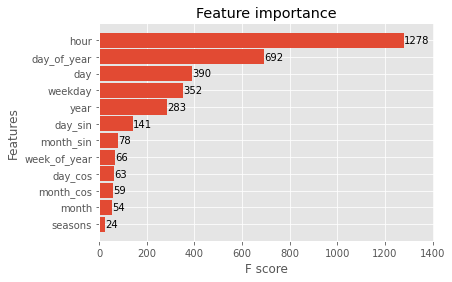

In [27]:
from xgboost import XGBRegressor, plot_importance, XGBRFRegressor
# params = {'n_estimators': 1000,
#         'seed': 0, 'colsample_bytree': 0.5609381638923877, 'gamma': 1.1445734139912174, 'max_depth': 3, 'min_child_weight': 10.0, 'reg_alpha': 158.0, 'reg_lambda': 0.441079730155739}
reg = XGBRegressor(n_estimators=1000, n_jobs=-1)
# reg = CatBoostRegressor()
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse',
        early_stopping_rounds=50,
       verbose=False)

_ = plot_importance(reg, height=0.9)

In [22]:
##test
test_t = create_features(test, 'date', label=None)

In [28]:
pred_t = reg.predict(test_t)

In [29]:
test = pd.read_csv("test_6QvDdzb.csv")
# test.head()
sub = pd.DataFrame()
sub = test[['date', 'hour']]
sub['demand'] = pred_t#p.round(np.expm1(np.maximum(reg.predict(test_t), 0.0)))
sub.to_csv(f"Submission_L{time.strftime('%Y%m%d_%H%M')}.csv", index=False)

In [30]:
sub.head()

,date,hour,demand
0,2021-03-01,0,59.308830
1,2021-03-01,1,53.078922
2,2021-03-01,2,53.078922
3,2021-03-01,3,53.078922
4,2021-03-01,5,52.131901


In [45]:
x = pd.read_csv('submission_L20220424_1048_33.16.csv') #xgb
y = pd.read_csv('submission_L20220424_1406_32.99_cbst.csv')#catboost
z = pd.read_csv('submission_L20220424_1423_32.93_lgbm.csv')#lgbm feature engineered
w = pd.read_csv('Submission_L20220424_1748_32.85_lgbm.csv')#lgbm feature engineered2

In [46]:
# mean = (z['demand']+y['demand']+w['demand'])/3 #32.77

In [47]:
# mean = (z['demand']+w['demand'])/2 #32.78

In [48]:
from scipy.stats.mstats import gmean
preds = pd.concat([x['demand'],y['demand'],z['demand'],w['demand']])
preds = preds.groupby(level=0).apply(gmean)

In [49]:
mean = (x['demand']+y['demand']+z['demand']+w['demand'])/4 #32.77
import time

test = pd.read_csv("test_6QvDdzb.csv")
# test.head()
sub = pd.DataFrame()
sub = test[['date', 'hour']]
sub['demand'] = mean #preds #p.round(np.expm1(np.maximum(reg.predict(test_t), 0.0)))
sub.to_csv(f"gmsubmission_L{time.strftime('%Y%m%d_%H%M')}.csv", index=False)

In [50]:
sub.head()

,date,hour,demand
0,2021-03-01,0,57.917243
1,2021-03-01,1,55.102404
2,2021-03-01,2,56.035368
3,2021-03-01,3,56.188246
4,2021-03-01,5,57.166387
